# dataset sharecaptioner caption/image

In [1]:
import json

with open('/ML-A100/team/mm/gujiasheng/Long-CLIP/train/sharegpt4v/data/share-captioner_coco_lcs_sam_1246k_1107.json') as f:
    data = json.load(f)

In [2]:
len(data)

1246901

In [18]:
import os
s = set()
for d in data:
    if d['image'].startswith('sam'):
        print(d)
        break


{'id': 'sa_545504', 'image': 'sam/images/sa_545504.jpg', 'conversations': [{'from': 'human', 'value': "<image>\nWhat is this photo about'?"}, {'from': 'gpt', 'value': "The image captures a breathtaking view of the Hong Kong skyline at sunset. The sky, awash with hues of orange and blue, serves as a stunning backdrop to the city's architectural marvels. The tallest building, the International Finance Centre, pierces the sky with its imposing height. Its lights are switched on, casting a warm glow that contrasts with the cool tones of the evening sky.\n\nThe other buildings, though not as tall, are no less impressive. They are adorned with lights that twinkle like stars against the twilight sky. The water below mirrors the sky's colors, adding to the overall vibrancy of the scene.\n\nThe perspective of the image is from the water, looking towards the shore. This viewpoint allows for a comprehensive view of the cityscape, from the towering skyscrapers to the smaller structures nestled amo

In [4]:
import pandas as pd
import json
import os
from tqdm import tqdm

_INPUT_IMAGES = "flickr30k-images"
_JSON_KEYS = ['raw', 'sentids']

def _generate_examples(examples_csv, images_dir):
    """Yields examples."""
    df = pd.read_csv(examples_csv)
    for c in _JSON_KEYS:
        df[c] = df[c].apply(json.loads)
    images = []
    captions = []
    for r_idx, r in df.iterrows():
        r_dict = r.to_dict()
        image_path = os.path.join(images_dir, _INPUT_IMAGES, r_dict['filename'])
        r_dict['image'] = image_path
        r_dict['caption'] = r_dict.pop('raw')
        images.append(r_dict['image'])
        captions.extend(r_dict['caption'])
    return images, captions

images, captions = _generate_examples("/ML-A100/team/mm/gujiasheng/Long-CLIP/eval/retrieval/flickr_annotations_30k.csv", "/ML-A100/team/mm/gujiasheng/Long-CLIP/eval/retrieval/")

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from sharegpt4v import share4v_val_dataset, share4v_train_dataset
batch_size = 32
num_processes = 2
import torch
trainset = share4v_train_dataset(
    model_name="ViT-L/14",
    batch_size=batch_size,
    num_processes=num_processes,
)
train_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, num_workers=32, pin_memory=True, shuffle=True
)


In [2]:

import open_clip

import torch
from sharegpt4v import share4v_val_dataset, share4v_train_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
#             "ViT-L-14", pretrained="openai", device=device
#         )
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
            "ViT-bigG-14", pretrained="laion2b_s39b_b160k", device=device
        )
preprocess = preprocess_val

# tokenizer = open_clip.get_tokenizer("ViT-L-14")
tokenizer = open_clip.get_tokenizer("ViT-bigG-14")
test_batch_size = 1000
# base_model = "ViT-L/14"
base_model = "ViT-bigG-14"
testset = share4v_val_dataset(
    model_name=base_model,
    batch_size=test_batch_size,
    preprocess=preprocess_val,
)

test_dataloader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, num_workers=32, pin_memory=True
)

In [3]:
with torch.no_grad():
    for images, texts, targets in test_dataloader:
        images = images.cuda()
        texts = tokenizer(texts)
        # texts[:, 60: ] = 49407
        texts = texts.cuda()
        image_features = model.encode_image(images)
        text_features = model.encode_text(texts)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        sim_i2t = torch.matmul(image_features, text_features.T)
        sim_i2t = 100 * sim_i2t
        targets = targets.to(sim_i2t.device)
        correct = (sim_i2t.argmax(1) == targets).sum()
    acc = correct / test_batch_size

    print("=====================================")
    print(f"test mean of share4v retrieval: {acc}")
    print("=====================================")

test mean of share4v retrieval: 0.9390000700950623


In [9]:
texts

tensor([[49406,   518,  2867,  ...,   269,   902,  3073],
        [49406,   518,  2867,  ...,  1762,   269,  4564],
        [49406,   518,  2867,  ...,  5285,   267,   320],
        ...,
        [49406,   518,  2867,  ...,  3562,   269,   530],
        [49406,   518,  2867,  ...,  3638,    85,  1032],
        [49406,   530,   518,  ...,   736,  2523,   267]], device='cuda:0')

L                                                       bigg
test mean of share4v retrieval: 0.843000054359436, 77
test mean of share4v retrieval: 0.8140000104904175 60 test mean of share4v retrieval: 0.9050000309944153 60
test mean of share4v retrieval: 0.7820000648498535 50 test mean of share4v retrieval: 0.878000020980835  50
test mean of share4v retrieval: 0.7410000562667847 40 test mean of share4v retrieval: 0.8580000400543213 40
test mean of share4v retrieval: 0.6760000586509705 30 test mean of share4v retrieval: 0.8100000619888306 30
test mean of share4v retrieval: 0.5860000252723694 20 test mean of share4v retrieval: 0.6850000619888306 20 

In [5]:
import json
def _generate_examples(examples_json):
    """Yields examples."""
    images = []
    captions = []
    with open(examples_json, 'r') as f:
        dataset = json.load(f)
        for r in dataset:
            images.append(r['image'])
            captions.append(r['conversations'][1]["value"])
    return images, captions

images, captions = _generate_examples("/ML-A100/team/mm/gujiasheng/Long-CLIP/eval/retrieval/gpt4v_api_chat_240406.034614_onlyLocalPath_long.json")

In [9]:
images[2]

'/ML-A100/team/mm/wangjiazhi/01_data/miniGemini_method/forGPT4v_240403/images/54311_4524900322_f6da5dfc7c.jpg'

In [6]:
captions

["Photorealistic capture of a 1960s-era Formula One racing car, presented in a sharp black and white contrast that emphasizes the car's streamlined design and the fleeting moment of the race. Bearing the number 12, the car's details, from its wide-profile tires designed for grip to the smooth curves that delineate its form, are meticulously shown. The vehicle is mid-turn on a racetrack, its motion suggested by the blurred background where focused spectators and hay bales lining the course are visible. The low-angle shot creates a dramatic perspective, underlining both the speed and the historic nature of the open-cockpit, single-seat race car as it competes.",
 "Photorealistic long exposure image, showcasing the dramatic landscape of Reynisfjara beach at sunrise. Dark, distinct silhouettes of jagged sea stacks pierce the horizon, as a muted sun illuminates sparse clouds in shades of orange and gold. The ocean, softened by the extended exposure time, appears as a foggy blanket caressing

# ROPE

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# This software may be used and distributed according to the terms of the Llama 2 Community License Agreement.

import math
from dataclasses import dataclass
from typing import Optional, Tuple

import fairscale.nn.model_parallel.initialize as fs_init
import torch
import torch.nn.functional as F
from fairscale.nn.model_parallel.layers import (
    ColumnParallelLinear,
    ParallelEmbedding,
    RowParallelLinear,
)
from torch import nn


@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = None
    vocab_size: int = 8  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    max_batch_size: int = 32
    max_seq_len: int = 2048


class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    """
    Precompute the frequency tensor for complex exponentials (cis) with given dimensions.

    This function calculates a frequency tensor with complex exponentials using the given dimension 'dim'
    and the end index 'end'. The 'theta' parameter scales the frequencies.
    The returned tensor contains complex values in complex64 data type.

    Args:
        dim (int): Dimension of the frequency tensor.
        end (int): End index for precomputing frequencies.
        theta (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.

    Returns:
        torch.Tensor: Precomputed frequency tensor with complex exponentials.

    
        

    """
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    """
    Reshape frequency tensor for broadcasting it with another tensor.

    This function reshapes the frequency tensor to have the same shape as the target tensor 'x'
    for the purpose of broadcasting the frequency tensor during element-wise operations.

    Args:
        freqs_cis (torch.Tensor): Frequency tensor to be reshaped.
        x (torch.Tensor): Target tensor for broadcasting compatibility.

    Returns:
        torch.Tensor: Reshaped frequency tensor.

    Raises:
        AssertionError: If the frequency tensor doesn't match the expected shape.
        AssertionError: If the target tensor 'x' doesn't have the expected number of dimensions.
    """
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply rotary embeddings to input tensors using the given frequency tensor.

    This function applies rotary embeddings to the given query 'xq' and key 'xk' tensors using the provided
    frequency tensor 'freqs_cis'. The input tensors are reshaped as complex numbers, and the frequency tensor
    is reshaped for broadcasting compatibility. The resulting tensors contain rotary embeddings and are
    returned as real tensors.

    Args:
        xq (torch.Tensor): Query tensor to apply rotary embeddings.
        xk (torch.Tensor): Key tensor to apply rotary embeddings.
        freqs_cis (torch.Tensor): Precomputed frequency tensor for complex exponentials.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tuple of modified query tensor and key tensor with rotary embeddings.

        

    """
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)


def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )


class Attention(nn.Module):
    """Multi-head attention module."""
    def __init__(self, args: ModelArgs):
        """
        Initialize the Attention module.

        Args:
            args (ModelArgs): Model configuration parameters.

        Attributes:
            n_kv_heads (int): Number of key and value heads.
            n_local_heads (int): Number of local query heads.
            n_local_kv_heads (int): Number of local key and value heads.
            n_rep (int): Number of repetitions for local heads.
            head_dim (int): Dimension size of each attention head.
            wq (ColumnParallelLinear): Linear transformation for queries.
            wk (ColumnParallelLinear): Linear transformation for keys.
            wv (ColumnParallelLinear): Linear transformation for values.
            wo (RowParallelLinear): Linear transformation for output.
            cache_k (torch.Tensor): Cached keys for attention.
            cache_v (torch.Tensor): Cached values for attention.

        """
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        model_parallel_size = fs_init.get_model_parallel_world_size()
        self.n_local_heads = args.n_heads // model_parallel_size
        self.n_local_kv_heads = self.n_kv_heads // model_parallel_size
        self.n_rep = self.n_local_heads // self.n_local_kv_heads
        self.head_dim = args.dim // args.n_heads

        self.wq = ColumnParallelLinear(
            args.dim,
            args.n_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
        )
        self.wk = ColumnParallelLinear(
            args.dim,
            self.n_kv_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
        )
        self.wv = ColumnParallelLinear(
            args.dim,
            self.n_kv_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
        )
        self.wo = RowParallelLinear(
            args.n_heads * self.head_dim,
            args.dim,
            bias=False,
            input_is_parallel=True,
            init_method=lambda x: x,
        )

        self.cache_k = torch.zeros(
            (
                args.max_batch_size,
                args.max_seq_len,
                self.n_local_kv_heads,
                self.head_dim,
            )
        ).cuda()
        self.cache_v = torch.zeros(
            (
                args.max_batch_size,
                args.max_seq_len,
                self.n_local_kv_heads,
                self.head_dim,
            )
        ).cuda()

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        """
        Forward pass of the attention module.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Starting position for caching.
            freqs_cis (torch.Tensor): Precomputed frequency tensor.
            mask (torch.Tensor, optional): Attention mask tensor.

        Returns:
            torch.Tensor: Output tensor after attention.

        """
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)

        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)

        self.cache_k = self.cache_k.to(xq)
        self.cache_v = self.cache_v.to(xq)

        self.cache_k[:bsz, start_pos : start_pos + seqlen] = xk
        self.cache_v[:bsz, start_pos : start_pos + seqlen] = xv

        keys = self.cache_k[:bsz, : start_pos + seqlen]
        values = self.cache_v[:bsz, : start_pos + seqlen]

        # repeat k/v heads if n_kv_heads < n_heads
        keys = repeat_kv(keys, self.n_rep)  # (bs, cache_len + seqlen, n_local_heads, head_dim)
        values = repeat_kv(values, self.n_rep)  # (bs, cache_len + seqlen, n_local_heads, head_dim)

        xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        keys = keys.transpose(1, 2) # (bs, n_local_heads, cache_len + seqlen, head_dim)
        values = values.transpose(1, 2) # (bs, n_local_heads, cache_len + seqlen, head_dim)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores + mask  # (bs, n_local_heads, seqlen, cache_len + seqlen)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, values)  # (bs, n_local_heads, seqlen, head_dim)
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)
        return self.wo(output)


class FeedForward(nn.Module):
    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        multiple_of: int,
        ffn_dim_multiplier: Optional[float],
    ):
        """
        Initialize the FeedForward module.

        Args:
            dim (int): Input dimension.
            hidden_dim (int): Hidden dimension of the feedforward layer.
            multiple_of (int): Value to ensure hidden dimension is a multiple of this value.
            ffn_dim_multiplier (float, optional): Custom multiplier for hidden dimension. Defaults to None.

        Attributes:
            w1 (ColumnParallelLinear): Linear transformation for the first layer.
            w2 (RowParallelLinear): Linear transformation for the second layer.
            w3 (ColumnParallelLinear): Linear transformation for the third layer.

        """
        super().__init__()
        hidden_dim = int(2 * hidden_dim / 3)
        # custom dim factor multiplier
        if ffn_dim_multiplier is not None:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = ColumnParallelLinear(
            dim, hidden_dim, bias=False, gather_output=False, init_method=lambda x: x
        )
        self.w2 = RowParallelLinear(
            hidden_dim, dim, bias=False, input_is_parallel=True, init_method=lambda x: x
        )
        self.w3 = ColumnParallelLinear(
            dim, hidden_dim, bias=False, gather_output=False, init_method=lambda x: x
        )

    def forward(self, x):
        return self.w2(F.silu(self.w1(x)) * self.w3(x))


class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs):
        """
        Initialize a TransformerBlock.

        Args:
            layer_id (int): Identifier for the layer.
            args (ModelArgs): Model configuration parameters.

        Attributes:
            n_heads (int): Number of attention heads.
            dim (int): Dimension size of the model.
            head_dim (int): Dimension size of each attention head.
            attention (Attention): Attention module.
            feed_forward (FeedForward): FeedForward module.
            layer_id (int): Identifier for the layer.
            attention_norm (RMSNorm): Layer normalization for attention output.
            ffn_norm (RMSNorm): Layer normalization for feedforward output.

        """
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args)
        self.feed_forward = FeedForward(
            dim=args.dim,
            hidden_dim=4 * args.dim,
            multiple_of=args.multiple_of,
            ffn_dim_multiplier=args.ffn_dim_multiplier,
        )
        self.layer_id = layer_id
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        """
        Perform a forward pass through the TransformerBlock.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Starting position for attention caching.
            freqs_cis (torch.Tensor): Precomputed cosine and sine frequencies.
            mask (torch.Tensor, optional): Masking tensor for attention. Defaults to None.

        Returns:
            torch.Tensor: Output tensor after applying attention and feedforward layers.

        """
        h = x + self.attention(
            self.attention_norm(x), start_pos, freqs_cis, mask
        )
        out = h + self.feed_forward(self.ffn_norm(h))
        return out


class Transformer(nn.Module):
    def __init__(self, params: ModelArgs):
        """
        Initialize a Transformer model.

        Args:
            params (ModelArgs): Model configuration parameters.

        Attributes:
            params (ModelArgs): Model configuration parameters.
            vocab_size (int): Vocabulary size.
            n_layers (int): Number of layers in the model.
            tok_embeddings (ParallelEmbedding): Token embeddings.
            layers (torch.nn.ModuleList): List of Transformer blocks.
            norm (RMSNorm): Layer normalization for the model output.
            output (ColumnParallelLinear): Linear layer for final output.
            freqs_cis (torch.Tensor): Precomputed cosine and sine frequencies.

        """
        super().__init__()
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        self.tok_embeddings = ParallelEmbedding(
            params.vocab_size, params.dim, init_method=lambda x: x
        )

        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            self.layers.append(TransformerBlock(layer_id, params))

        self.norm = RMSNorm(params.dim, eps=params.norm_eps)
        self.output = ColumnParallelLinear(
            params.dim, params.vocab_size, bias=False, init_method=lambda x: x
        )

        self.freqs_cis = precompute_freqs_cis(
            # Note that self.params.max_seq_len is multiplied by 2 because the token limit for the Llama 2 generation of models is 4096. 
            # Adding this multiplier instead of using 4096 directly allows for dynamism of token lengths while training or fine-tuning.
            self.params.dim // self.params.n_heads, self.params.max_seq_len * 2
        )

    @torch.inference_mode()
    def forward(self, tokens: torch.Tensor, start_pos: int):
        """
        Perform a forward pass through the Transformer model.

        Args:
            tokens (torch.Tensor): Input token indices.
            start_pos (int): Starting position for attention caching.

        Returns:
            torch.Tensor: Output logits after applying the Transformer model.

        """
        _bsz, seqlen = tokens.shape
        h = self.tok_embeddings(tokens)
        self.freqs_cis = self.freqs_cis.to(h.device)
        freqs_cis = self.freqs_cis[start_pos : start_pos + seqlen]

        mask = None
        if seqlen > 1:
            mask = torch.full(
                (seqlen, seqlen), float("-inf"), device=tokens.device
            )

            mask = torch.triu(mask, diagonal=1)

            # When performing key-value caching, we compute the attention scores
            # only for the new sequence. Thus, the matrix of scores is of size
            # (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
            # j > cache_len + i, since row i corresponds to token cache_len + i.
            mask = torch.hstack([
                torch.zeros((seqlen, start_pos), device=tokens.device),
                mask
            ]).type_as(h)

        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)
        h = self.norm(h)
        output = self.output(h).float()
        return output

In [2]:
import torch
import torch.distributed as dist
from fairscale.nn.model_parallel import initialize_model_parallel
import os
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'

torch.distributed.init_process_group(
    backend='nccl',  # or 'gloo' if you are not using CUDA
    init_method='env://',  # Assumes environment variables are set for rank and world size
    world_size=1,  # Total number of processes
    rank=0  # Rank of the current process
)
initialize_model_parallel(model_parallel_size_=1)  # Adjust based on your needs


> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


In [10]:

tsfr = Transformer(ModelArgs())


In [7]:

x = torch.ones(1, ModelArgs.max_seq_len)
x = x.long()
type(x)

torch.Tensor

In [9]:
tsfr(x, start_pos=0)

tensor([[[nan, nan, nan,  ..., nan, nan, 0.],
         [nan, nan, nan,  ..., nan, nan, 0.],
         [nan, nan, nan,  ..., nan, nan, 0.],
         ...,
         [nan, nan, nan,  ..., nan, nan, 0.],
         [nan, nan, nan,  ..., nan, nan, 0.],
         [nan, nan, nan,  ..., nan, nan, 0.]]])

# dataset yivl caption/image

In [1]:
dataset_json_dirs = [
    "/ML-A100/team/mm/wangjiazhi/01_data/midjourney-messages_202308after/json",
    "/ML-A100/team/mm/wangjiazhi/01_data/photography/pexels/json",
    "/ML-A100/team/mm/wangjiazhi/01_data/alphacoders/json",
    "/ML-A100/team/mm/wangjiazhi/01_data/midjourney-messages_202308before/20240221/json",
    "/ML-A100/team/mm/wangjiazhi/01_data/midjourney-messages_202308before/20240224/json",
    "/ML-A100/team/mm/wangjiazhi/01_data/openniji/json",
]
import glob
import json
import os
from tqdm import tqdm

paths = []
for dataset_json_dir in dataset_json_dirs:
    paths.extend(glob.glob(os.path.join(dataset_json_dir, "*/*.json")))
    # break
print(len(paths))
import json
import random

# Define the file path
file_path = 'yivl_data_paths.json'

random.shuffle(paths)
# Convert the paths variable to JSON format
paths_json = json.dumps(paths)

# Write the JSON data to the file
with open(file_path, 'w') as file:
    file.write(paths_json)

print(f"Paths saved to {file_path}")

11006566
Paths saved to yivl_data_paths.json


In [5]:
import open_clip
model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-bigG-14", pretrained="laion2b_s39b_b160k"
)

In [22]:
from model import longclip
import torch
from PIL import Image

vit = torch.load("ViT-bigG-14.pth")
vit = vit.cuda()
transform = longclip._transform(224)

In [45]:
def encode_image(path):
    img1 = Image.open(path)
    img1 = transform(img1).unsqueeze(0)
    img1 = img1.cuda()
    img1 = vit(img1)
    return img1 / img1.norm(dim=-1, keepdim=True)

In [46]:
img1 = encode_image("/ML-A100/team/mm/wangjiazhi/01_data/midjourney-messages_202308before/20240224/images/000035/1130830786631835658.png")
img2 = encode_image("/ML-A100/team/mm/wangjiazhi/01_data/midjourney-messages_202308before/20240224/images/000025/1081317567685206066.png")

In [50]:
img2@img1.T

tensor([[0.4612]], device='cuda:0', grad_fn=<MmBackward0>)

In [8]:
trainset = share4v_train_dataset(num_processes=1, preprocess=transform)

In [4]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

image_paths = []

def process_file(path):
    try:
        with open(path, "r", encoding="utf8") as fp:
            data = json.load(fp)
        return data["img_path"]
    except:
        return None

# 使用 ThreadPoolExecutor 并行处理文件
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(process_file, path): path for path in trainset.json_data}
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if result:
            image_paths.append(result)


100%|██████████| 11008119/11008119 [18:54<00:00, 9702.25it/s] 


In [1]:
import json

# Define the file path
file_path = 'image_paths.json'

# Convert the image_paths variable to JSON format
image_paths_json = json.dumps(image_paths)

# Write the JSON data to the file
with open(file_path, 'w') as file:
    file.write(image_paths_json)

print(f"Image paths saved to {file_path}")


NameError: name 'image_paths' is not defined

In [29]:
train_dataloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=512,
    num_workers=32,
    pin_memory=True,
    shuffle=True,
)

torch.Size([3, 224, 224])

In [10]:
image_tensors = []
for i in tqdm(range(len(trainset))[:1000]):
    image_tensors.append(trainset[i].unsqueeze(0).cuda())

100%|██████████| 1000/1000 [01:29<00:00, 11.14it/s]


In [11]:
vit = vit.cuda()

In [13]:

for image_tensor in tqdm(image_tensors):
    output_tensor = vit(image_tensor)
    np.save("output_tensor.npy", output_tensor.cpu().detach().numpy())

100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s]


In [4]:
from model import longclip

model, transform = longclip.load("/ML-A100/team/mm/gujiasheng/Long-CLIP/ViT-bigG-14-laion2b_s39b_b160k.pt", device="cpu")

RuntimeError: Error(s) in loading state_dict for CLIP:
	Missing key(s) in state_dict: "positional_embedding_res". 
	size mismatch for positional_embedding: copying a param with shape torch.Size([77, 1280]) from checkpoint, the shape in current model is torch.Size([248, 1280]).

In [3]:
from model import longclip

model, transform = longclip.load("/ML-A100/team/mm/gujiasheng/Long-CLIP/train/lr=1e-06_wd=0.01_wl=200_log_scale=4.6052_bs=512_ViT-bigG-14-laion2b_s39b_b160k/ckpt/longclip-bigG_epoch_5.pt", device="cuda")

KeyboardInterrupt: 

In [22]:
image_tensor, texts, texts_short, index = trainset[0]

In [23]:
texts = longclip.tokenize(texts, truncate=True)
texts_short = longclip.tokenize(texts_short, truncate=True)

In [29]:
model(image_tensor.cuda().unsqueeze(0), texts.cuda(), texts_short.cuda())

/ML-A100/team/mm/gujiasheng/Long-CLIP/model/model_longclip.py:607: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1711403388920/work/aten/src/ATen/native/Copy.cpp:301.)
  eigenvalues = eigenvalues.float()


(tensor([[ 0.0298,  0.0141,  0.0097,  ..., -0.0093,  0.0159,  0.0007]],
        device='cuda:0', dtype=torch.float16),
 tensor([[ 0.0003,  0.0167,  0.0172,  ...,  0.0081, -0.0101, -0.0105]],
        device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>),
 tensor([[ 0.0298,  0.0141,  0.0097,  ..., -0.0093,  0.0159,  0.0007]],
        device='cuda:0'),
 tensor([[ 0.0145,  0.0131, -0.0024,  ...,  0.0035, -0.0181, -0.0123]],
        device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>),
 tensor(99.9886, device='cuda:0', grad_fn=<ExpBackward0>))

In [7]:
from train.yivl import share4v_val_dataset, share4v_train_dataset
from model import longclip
trainset = share4v_train_dataset(preprocess=longclip._transform(224))
testset = share4v_val_dataset(preprocess=longclip._transform(224))

In [4]:
import torch
train_dataloader = torch.utils.data.DataLoader(
            trainset,
            batch_size=512,
            num_workers=32,
            pin_memory=True,
            shuffle=True,
        )
test_dataloader = torch.utils.data.DataLoader(
            testset, batch_size=512, num_workers=32
        )

In [21]:
# Assuming you have a list named 'my_list'
import torch
my_list = [2]
my_list.extend([-1] * (512 - len(my_list)))
torch.tensor(my_list, dtype=torch.int).shape

torch.Size([512])

In [4]:
testset.json_data[-1]

'/ML-A100/team/mm/wangjiazhi/01_data/midjourney-messages_202308after/json/000044/1142212156943777954.json'

In [6]:
for i in test_dataloader:
    print(i)
    break

In [5]:
for i in tqdm(train_dataloader):
    print(i)
    break

/ML-A100/team/mm/gujiasheng/miniconda3/envs/aa/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (99337374 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/ML-A100/team/mm/gujiasheng/miniconda3/envs/aa/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/ML-A100/team/mm/gujiasheng/miniconda3/envs/aa/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (133696772 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/ML-A100/team/mm/gujiasheng/miniconda3/envs/aa/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (101082464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[tensor([[[[-0.8580, -0.8288, -0.7996,  ..., -0.8726, -0.8872, -0.9018],
          [-0.9748, -0.9602, -0.9602,  ..., -0.9748, -0.9748, -0.9893],
          [-0.9310, -0.9310, -0.9164,  ..., -0.9602, -0.9602, -0.9748],
          ...,
          [-0.1572, -0.1280, -0.0842,  ..., -0.2740, -0.2886, -0.2886],
          [-0.2448, -0.2010, -0.1572,  ..., -0.3762, -0.4054, -0.4200],
          [-0.2594, -0.2448, -0.2010,  ..., -0.5222, -0.5514, -0.6098]],

         [[-0.7316, -0.6865, -0.6415,  ..., -0.6565, -0.6865, -0.7016],
          [-0.7466, -0.7316, -0.7016,  ..., -0.7016, -0.7316, -0.7316],
          [-0.6565, -0.6415, -0.6265,  ..., -0.6565, -0.6565, -0.6715],
          ...,
          [-0.7466, -0.7166, -0.7166,  ..., -0.8216, -0.8216, -0.8216],
          [-0.8066, -0.7466, -0.7466,  ..., -0.8366, -0.8516, -0.8666],
          [-0.7466, -0.7166, -0.7016,  ..., -0.8366, -0.8666, -0.9117]],

         [[-0.5417, -0.5133, -0.4848,  ..., -0.4848, -0.4990, -0.5133],
          [-0.5417, -0.5275, 

In [5]:
torch.where(torch.rand(10,10) > 0.5)

(tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
         5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9]),
 tensor([1, 3, 4, 6, 7, 8, 0, 1, 3, 5, 0, 4, 8, 0, 5, 6, 9, 1, 4, 5, 6, 7, 8, 9,
         2, 3, 8, 9, 5, 7, 1, 3, 5, 8, 9, 0, 1, 2, 4, 7, 8, 9, 0, 4, 5, 6, 7]))

In [2]:
import torch
high_similarity_indices = torch.where(torch.rand(10,10) > 0.5)


In [5]:
high_similarity_indices[0] = high_similarity_indices[0]+1
high_similarity_indices

TypeError: 'tuple' object does not support item assignment

In [9]:
import torch

# Example data
high_similarity_indices = torch.where(torch.rand(10,10) > 0.5)
targets = range(4, 9)

# Convert targets to a tensor for efficient comparison
targets_tensor = torch.tensor(targets)

# Create a mask for filtering
mask = torch.any(high_similarity_indices[0][:, None] == targets_tensor, dim=1)

# Apply the mask to filter rows
filtered_indices = high_similarity_indices[0][mask]

print(filtered_indices)

tensor([4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
        7, 7, 8, 8, 8, 8, 8])


In [15]:
torch.where(torch.rand(10,10) > 0.5)

(tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9]),
 tensor([2, 3, 5, 9, 2, 3, 7, 8, 9, 5, 6, 8, 9, 0, 1, 2, 3, 5, 6, 7, 1, 2, 4, 6,
         8, 9, 4, 7, 9, 0, 1, 2, 5, 7, 2, 3, 6, 7, 1, 3, 5, 6, 0, 1, 2, 4, 8]))

In [14]:
(high_similarity_indices[0][mask], high_similarity_indices[1][mask])

(tensor([4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
         7, 7, 8, 8, 8, 8, 8]),
 tensor([1, 2, 3, 4, 9, 0, 1, 2, 4, 6, 7, 0, 1, 4, 5, 6, 7, 9, 0, 1, 2, 3, 5, 6,
         8, 9, 0, 2, 5, 6, 7]))

In [11]:
(high_similarity_indices[0][:, None] == targets_tensor).shape

torch.Size([56, 5])

In [1]:
import gzip

bpe_path = "/ML-A100/team/mm/gujiasheng/Long-CLIP/model/bpe_simple_vocab_16e6.txt.gz"
merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
merges = merges[1:49152-256-2+1]
merges = [tuple(merge.split()) for merge in merges]

In [8]:
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))
vocab = list(bytes_to_unicode().values())
vocab = vocab + [v+'</w>' for v in vocab]
for merge in merges:
    vocab.append(''.join(merge))
vocab.extend(['<|startoftext|>', '<|endoftext|>'])

In [10]:
vocab[-1]

'<|endoftext|>'

In [1]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
)
small_288 = transforms.Compose([
    transforms.Resize(288),
    transforms.ToTensor(),
    normalize,
])
skew_320 = transforms.Compose([
    transforms.Resize([320, 320]),
    transforms.ToTensor(),
    normalize,
])

In [8]:
import torch
from PIL import Image

model = torch.jit.load("/ML-A100/team/mm/gujiasheng/Long-CLIP/sscd_disc_large.torchscript.pt")
img = Image.open("/ML-A100/team/mm/gujiasheng/Long-CLIP/a.png").convert('RGB')
batch = skew_320(img).unsqueeze(0)
embedding = model(batch)[0, :]

In [15]:
from autofaiss import build_index
index_key = "IVF4096,Flat"
build_index(embeddings="/ML-A100/team/mm/wangjiazhi/01_data/alphacoders/vit_emb/20240322/", index_path="my_index_folder/knn.index",
            index_infos_path="my_index_folder/index_infos.json", index_key=index_key, max_index_memory_usage="256G",
            current_memory_available="512G")

2024-06-04 03:42:13,078 [INFO]: Using 54 omp threads (processes), consider increasing --nb_cores if you have more
2024-06-04 03:42:13,080 [INFO]: Launching the whole pipeline 06/04/2024, 03:42:13
2024-06-04 03:42:13,080 [INFO]: Reading total number of vectors and dimension 06/04/2024, 03:42:13
100%|██████████| 40472/40472 [00:06<00:00, 5825.78it/s]
2024-06-04 03:42:22,066 [INFO]: There are 40472 embeddings of dim 1280
2024-06-04 03:42:22,067 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 8.9869 secs
2024-06-04 03:42:22,068 [INFO]: 	Compute estimated construction time of the index 06/04/2024, 03:42:22
2024-06-04 03:42:22,068 [INFO]: 		-> Train: 16.7 minutes
2024-06-04 03:42:22,069 [INFO]: 		-> Add: 0.6 seconds
2024-06-04 03:42:22,069 [INFO]: 		Total: 16.7 minutes
2024-06-04 03:42:22,070 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0012 secs
2024-06-04 03:42:22,070 [INFO]: 	Checking that your have enough memory available to create

(<faiss.swigfaiss_avx512.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7f3f201198c0> >,
 {'index_key': 'IVF4096,Flat',
  'index_param': 'nprobe=1658',
  'index_path': 'my_index_folder/knn.index',
  'size in bytes': 228544843,
  'avg_search_speed_ms': 9.873814803544477,
  '99p_search_speed_ms': 10.803894512355328,
  'reconstruction error %': 0.0,
  'nb vectors': 40472,
  'vectors dimension': 1280,
  'compression ratio': 0.9066782574481456})

In [1]:
import faiss
import numpy as np
index = faiss.read_index("my_index_folder/knn.index", faiss.IO_FLAG_MMAP | faiss.IO_FLAG_READ_ONLY)
embeddings = np.float32(np.random.rand(1, 1280))
query_vector = np.float32(np.random.rand(1, 100))
k = 10
distances, indices = index.search(embeddings, k)

print(f"Top {k} elements in the dataset for max inner product search:")
for i, (dist, indice) in enumerate(zip(distances[0], indices[0])):
  print(f"{i+1}: Vector number {indice:4} with distance {dist}")

quantizer = index.quantizer
# centroids = faiss.vector_to_array(quantizer.xb).reshape(index.nlist, index.d)

# 获取每个簇的成员向量索引
nlist = index.nlist
invlists = index.invlists

# 获取每个簇对应的向量索引
clusters = {i: [] for i in range(nlist)}

for list_no in range(nlist):
    list_size = invlists.list_size(list_no)
    if list_size == 0:
        continue
    list_indices = faiss.rev_swig_ptr(invlists.get_ids(list_no), list_size)
    clusters[list_no].extend(list_indices)


Top 10 elements in the dataset for max inner product search:
1: Vector number 15676 with distance 57.8017578125
2: Vector number 19552 with distance 55.84168243408203
3: Vector number 37591 with distance 54.15003967285156
4: Vector number 25662 with distance 51.64789581298828
5: Vector number 15671 with distance 50.38356399536133
6: Vector number 27715 with distance 49.52873229980469
7: Vector number 1050 with distance 49.433597564697266
8: Vector number 18845 with distance 49.11872100830078
9: Vector number 2664 with distance 48.00096130371094
10: Vector number 4402 with distance 46.43224334716797


In [3]:
import faiss

def find_duplicate_items_in_cluster(vecs, items, index, thresh):
    """
    Find duplicate items in a cluster using FAISS index for similarity search.
    
    Parameters:
    vecs (list of lists): List of vectors in a single cluster.
    items (list): List of item IDs corresponding to vecs.
    index (faiss.Index): FAISS index for similarity search within the cluster.
    thresh (float): Threshold for determining duplicates.
    
    Returns:
    set: Set of duplicate item IDs.
    """
    dups = set()

    for i in range(len(vecs)):
        qs = np.array(vecs[i]).reshape((1, -1))  # Current vector
        qid = items[i]  # Current item ID

        # Perform range search within the threshold
        lims, D, I = index.range_search(qs, thresh)

        if qid in dups:
            continue

        start = lims[0]
        end = lims[1]
        duplicate_indices = I[start:end]

        duplicate_ids = []

        for j in duplicate_indices:
            if items[j] != qid:
                duplicate_ids.append(items[j])

        dups.update(duplicate_ids)

    return dups

# Example usage
# Assuming vecs is a list of vectors, items is a list of item IDs, and index is a pre-built FAISS index
# vecs = [...]
# items = [...]
# index = faiss.IndexFlatL2(d)  # or any other FAISS index
thresh = 0.5  # Example threshold

duplicates = find_duplicate_items_in_cluster(list(clusters.values()), list(clusters.keys()), index, thresh)
# print(duplicates)


AssertionError: 

/gpfs/public/vl/gjs/miniconda3/envs/sd/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


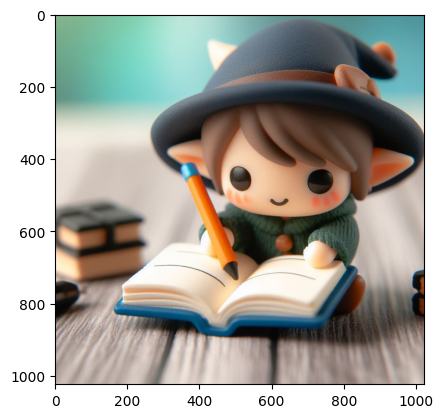

In [13]:
# %matplotlib inline
import matplotlib.pyplot as plt
import torch.utils.data
import torch.nn
from random import randrange
import os
os.environ["WDS_VERBOSE_CACHE"] = "1"
os.environ["GOPEN_VERBOSE"] = "0"

import webdataset as wds
url = '/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-{000001..000009}.tar'
pil_dataset = wds.WebDataset(url).shuffle(1000).decode("pil").to_tuple("png;jpg;jpeg", "json")

for image, json in pil_dataset:
    break
plt.imshow(image)

In [15]:
cnt = 0
print(cnt)
for image, json in pil_dataset:
    break
print(json)

0
{'image_name': '84bedb3fbdacb42c64bc8e71f19440dd.jpg', 'md5_pil_hash': '115abd7f4bd4838fa7b77f2a28da8076', 'md5_file_hash': '84bedb3fbdacb42c64bc8e71f19440dd', 'sha512_hash': '773cef9e9cba30643a13d3648c913460c3a31ed4b271d9faa3b0513f6d66d0c929544e90cf14a02195d18bd0f8eb2c133fe8c51c4fd1e6a35cdafa7ae6fe4a60', 'short_caption': 'A rural winter scene portrays a man pulling a horse-drawn wooden sled through an East Asian village, with children playing in the snow near traditional homes at its base.', 'long_caption': "The image depicts a serene winter landscape, possibly in East Asia, given the traditional attire of the people. In the foreground, there's a man wearing a straw hat and traditional clothing, pulling a wooden sled with a horse. The horse is adorned with a protective blanket. Beside him, a child, dressed in a red hood, is seated in the sled. The background showcases snow-covered houses with thatched roofs, nestled amidst snow-covered mountains. The atmosphere is calm, with a soft 

In [18]:
json['short_caption']

'A rural winter scene portrays a man pulling a horse-drawn wooden sled through an East Asian village, with children playing in the snow near traditional homes at its base.'

In [19]:
json['long_caption']

"The image depicts a serene winter landscape, possibly in East Asia, given the traditional attire of the people. In the foreground, there's a man wearing a straw hat and traditional clothing, pulling a wooden sled with a horse. The horse is adorned with a protective blanket. Beside him, a child, dressed in a red hood, is seated in the sled. The background showcases snow-covered houses with thatched roofs, nestled amidst snow-covered mountains. The atmosphere is calm, with a soft mist enveloping the mountains, adding to the tranquility of the scene."

In [20]:
import torch
a = torch.load('/gpfs/public/vl/gjs/Long-CLIP/checkpoints/ViT-L-14.pt')

/tmp/ipykernel_711751/1720597095.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = torch.load('/gpfs/public/vl/gjs/Long-CLIP/checkpoints/ViT-L-14.pt')
/gpfs/public/vl/

In [22]:
"visual.proj" in a

NotImplementedError: 

In [2]:
import glob

paths = glob.glob("/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/*")

In [12]:
import os
print(len(paths))
cnt = 0
for p in paths:
    if p.endswith('.json') or p.endswith('.jpeg') or p.endswith('.jpg') or p.endswith('.png'):
        continue
    print(p)
print(cnt*2)

2387498
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000057.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000024.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000053.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000056.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000013.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000062.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000050.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000019.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000055.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000010.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dal

/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000043.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000022.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000029.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000011.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/download_wget.sh
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000020.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000068.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000045.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000041.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-high-quality-captions/data-000003.tar
/gpfs/public/vl/gjs/dataset/synthetic-dataset-1m-dalle3-hig